In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Mofid

/content/drive/MyDrive/Mofid


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

***
# Loading Dataset

In [ ]:
TRAIN = "/content/drive/MyDrive/Mofid/train-3/"

# Run one example 
dir_list = os.listdir(TRAIN)
dir_list[0:5]

['2609MA.wav', '0020FW.wav', '0940MA.wav', '2202FN.wav', '1181MA.wav']

In [ ]:
# Get the data location for TRAIN
dir_list = os.listdir(TRAIN)

# parse the filename to get the emotions
emotion = []
gender = []
path = []

for i in dir_list:
    # gender
    if i[-6:-5]=='F':
        gender.append('female')
    elif i[-6:-5]=='M':
        gender.append('male')
    
    # emotion
    if i[-5:-4]=='A':
        emotion.append('angry')
    elif i[-5:-4]=='H':
        emotion.append('happy')
    elif i[-5:-4]=='S':
        emotion.append('sad')
    elif i[-5:-4]=='W':
        emotion.append('surprise')
    elif i[-5:-4]=='N':
        emotion.append('neutral')

    path.append(TRAIN + i)

# Now check out the label count distribution 
df = pd.DataFrame(path, columns = ['path'])
df = pd.concat([df, pd.DataFrame(gender, columns = ['gender'])], axis = 1)
df = pd.concat([df, pd.DataFrame(emotion, columns = ['emotions'])], axis = 1)
df.head()

,path,gender,emotions
0,/content/drive/MyDrive/Mofid/train-3/2609MA.wav,male,angry
1,/content/drive/MyDrive/Mofid/train-3/0020FW.wav,female,surprise
2,/content/drive/MyDrive/Mofid/train-3/0940MA.wav,male,angry
3,/content/drive/MyDrive/Mofid/train-3/2202FN.wav,female,neutral
4,/content/drive/MyDrive/Mofid/train-3/1181MA.wav,male,angry


In [ ]:
df.shape

(2221, 3)

In [ ]:
df.gender.value_counts()

male      1299
female     922
Name: gender, dtype: int64

In [ ]:
df.emotions.value_counts()

angry       795
neutral     782
sad         329
surprise    163
happy       152
Name: emotions, dtype: int64

In [ ]:
duration = []
for i,audio in enumerate(df.path):
  length = librosa.get_duration(filename=audio)
  duration.append(length)

In [ ]:
df['duration'] = duration
df.head()

,path,gender,emotions,duration
0,/content/drive/MyDrive/Mofid/train-3/2609MA.wav,male,angry,4.277687
1,/content/drive/MyDrive/Mofid/train-3/0020FW.wav,female,surprise,0.942063
2,/content/drive/MyDrive/Mofid/train-3/0940MA.wav,male,angry,2.787075
3,/content/drive/MyDrive/Mofid/train-3/2202FN.wav,female,neutral,9.598503
4,/content/drive/MyDrive/Mofid/train-3/1181MA.wav,male,angry,3.856100


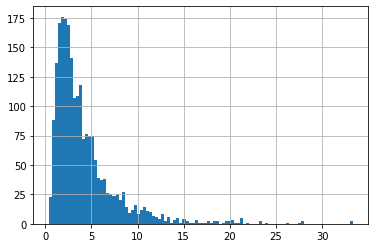

In [ ]:
df['duration'].hist(bins=100)

***
# Data Visualisation and Exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


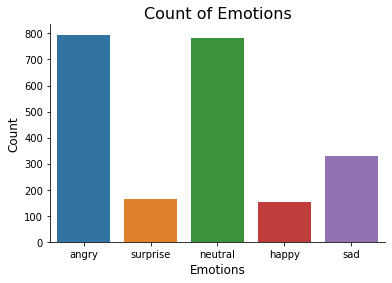

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(df.emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

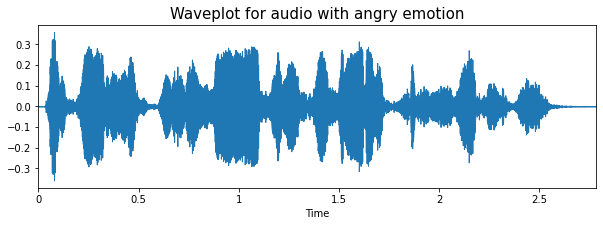

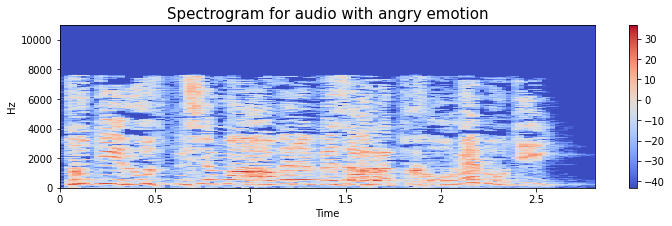

In [ ]:
emotion='angry'
path = np.array(df.path[df.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

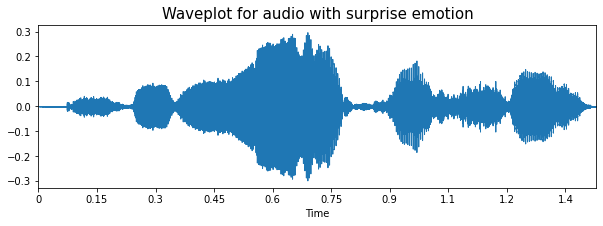

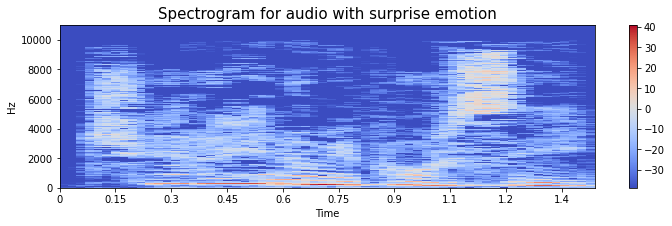

In [ ]:
emotion='surprise'
path = np.array(df.path[df.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

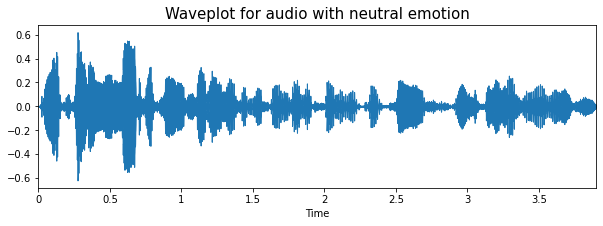

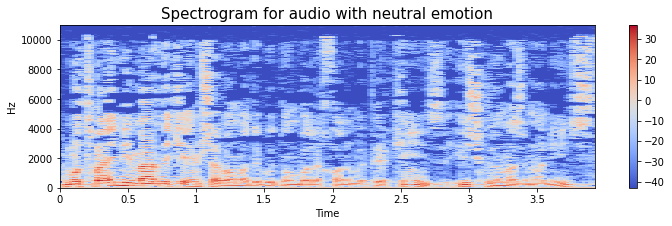

In [ ]:
emotion='neutral'
path = np.array(df.path[df.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

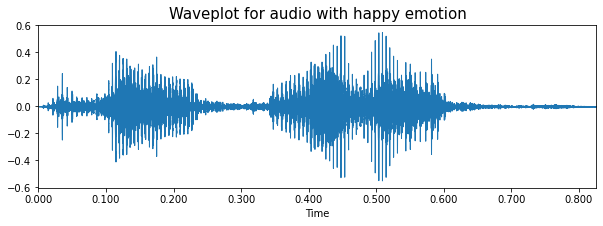

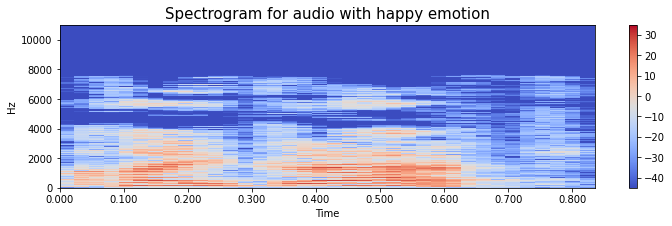

In [ ]:
emotion='happy'
path = np.array(df.path[df.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

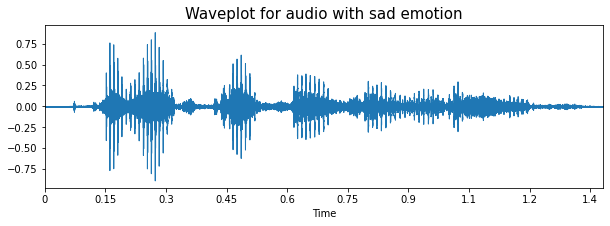

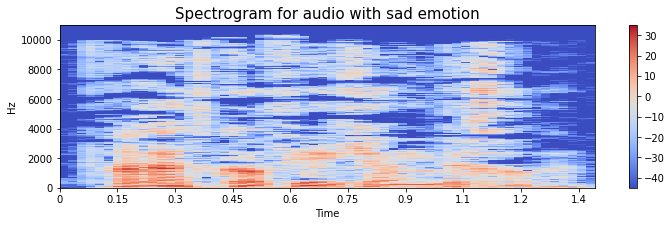

In [ ]:
emotion='sad'
path = np.array(df.path[df.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

***
# Data Augmentation
To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
# taking any example and checking for techniques.
path = np.array(df.path)[1]
data, sample_rate = librosa.load(path)

### Simple Audio

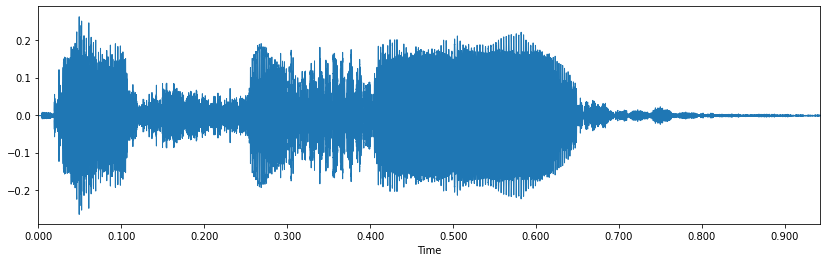

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

### Noise Injection


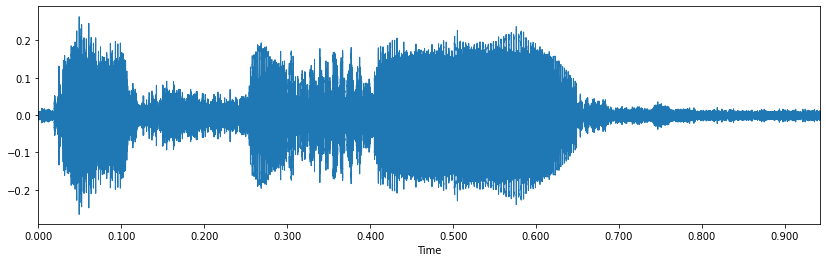

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Stretching

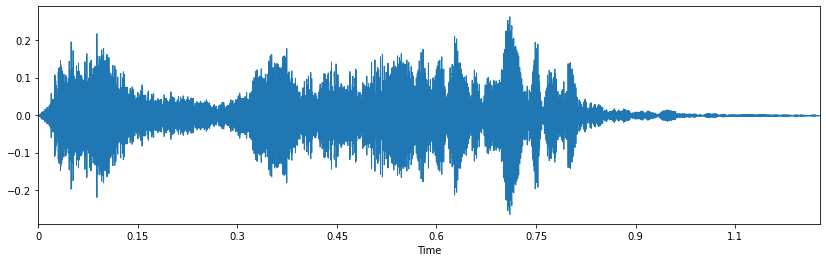

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Shifting

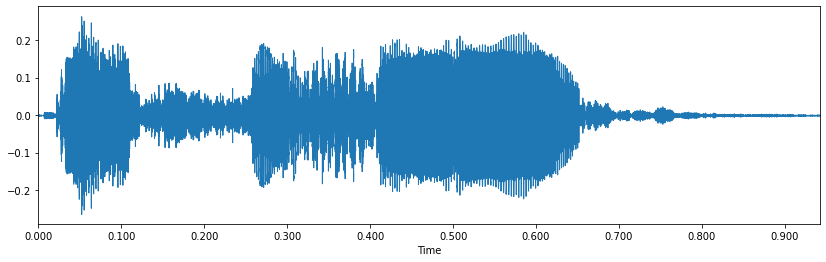

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Pitch

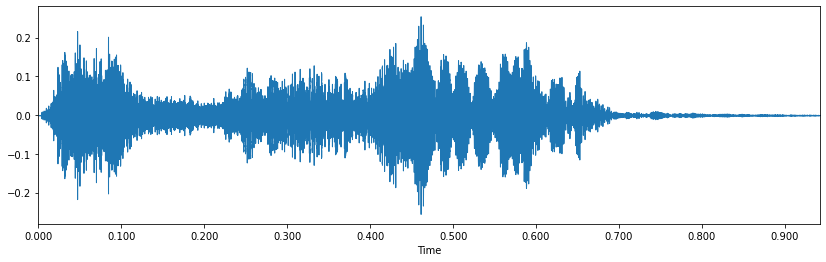

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

***
# Feature Extraction

In [ ]:
def extract_features(data):
  # ZCR
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result=np.hstack((result, zcr)) # stacking horizontally

  # Chroma_stft
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft)) # stacking horizontally

  # MFCC
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc)) # stacking horizontally

  # Root Mean Square Value
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms)) # stacking horizontally

  # MelSpectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel)) # stacking horizontally
  
  return result

def get_features(path):
  # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
  data, sample_rate = librosa.load(path)#, duration=2.5, offset=0.6)

  # without augmentation
  res1 = extract_features(data)
  result = np.array(res1)
  
  # data with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data)
  result = np.vstack((result, res2)) # stacking vertically
  
  # data with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch)
  result = np.vstack((result, res3)) # stacking vertically
  
  return result

In [ ]:
X, Y = [], []
i = 0
for path, emotion in zip(df.path, df.emotions):
  print(i)
  feature = get_features(path)
  i += 1
  for ele in feature:
    X.append(ele)
    # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    Y.append(emotion)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(X), len(Y), df.path.shape

(6663, 6663, (2221,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,labels
0,0.114828,0.546671,0.547991,0.568328,0.571146,0.597972,0.605048,0.633856,0.683829,0.719483,0.733075,0.638677,0.585796,-297.896393,107.955574,-20.650633,15.862342,-6.550250,2.541780,-8.934949,8.971520,-19.210056,7.186996,-11.329638,-17.533350,-11.301098,1.746207,-7.807005,-5.805370,-9.390061,2.586756,-4.095994,-2.415816,0.049512,0.048069,0.012759,0.030057,0.122693,1.240005,3.562165,...,0.012951,0.004362,0.002678,0.002017,0.002056,0.003787,0.006128,0.006963,0.004897,0.003646,0.003715,0.003075,0.002399,0.003573,0.006211,0.008358,0.007043,0.006648,0.003880,0.001282,0.001551,0.002903,0.005646,0.003944,0.001228,0.000424,0.000527,5.153937e-04,4.757370e-04,4.600303e-04,6.143706e-04,7.878737e-04,5.044953e-04,1.496551e-04,7.932479e-05,7.632635e-05,5.937337e-06,5.718263e-07,5.585927e-07,angry
1,0.254920,0.698375,0.700956,0.709435,0.719535,0.735370,0.677370,0.649459,0.693680,0.717124,0.746096,0.713148,0.697123,-168.686324,43.191807,3.766793,-0.255098,-2.791434,-3.394892,-1.481469,-2.267895,-6.494155,-4.108939,-5.676129,-10.812570,-6.819841,-3.716469,-3.926001,-5.739362,-5.224853,-2.141204,-2.455203,-3.564138,0.053143,0.055091,0.021353,0.038837,0.134354,1.251434,3.559094,...,0.024538,0.015003,0.013578,0.012526,0.012151,0.014086,0.016342,0.017491,0.014386,0.013253,0.013942,0.013474,0.013080,0.013656,0.016730,0.018689,0.017843,0.016805,0.014234,0.011564,0.011644,0.012930,0.015484,0.014568,0.011000,0.009752,0.010206,1.043799e-02,1.090032e-02,1.069870e-02,1.080975e-02,1.097140e-02,1.108573e-02,1.019246e-02,1.030887e-02,1.040154e-02,1.003629e-02,1.052549e-02,1.069108e-02,angry
2,0.122709,0.613869,0.556519,0.536577,0.554778,0.569129,0.617025,0.609274,0.601297,0.684536,0.696047,0.728267,0.657900,-350.689575,101.779526,-20.745871,13.172822,-8.622038,-1.130750,-7.472286,5.032075,-19.255808,5.919237,-16.762167,-17.826794,-7.586936,-0.284281,-9.607126,-8.809947,-5.698819,3.314649,-4.934489,-2.277961,0.022051,0.008835,0.002777,0.002980,0.014764,0.095411,0.421977,...,0.005587,0.004674,0.001779,0.000730,0.000536,0.000440,0.000694,0.000955,0.001714,0.001275,0.000904,0.000833,0.000669,0.000588,0.000452,0.000892,0.001549,0.001473,0.001575,0.000921,0.000511,0.000252,0.000537,0.000956,0.001431,0.000554,0.000121,1.034791e-04,1.222477e-04,1.022451e-04,9.128296e-05,1.079755e-04,1.427305e-04,1.330507e-04,6.084592e-05,1.642691e-05,1.408126e-05,3.831802e-06,2.618364e-09,angry
3,0.106255,0.428289,0.372447,0.426865,0.506903,0.671590,0.767671,0.594881,0.496018,0.530588,0.555218,0.572981,0.456595,-297.204559,118.180489,-34.420280,23.097862,-15.599856,24.254677,-12.859584,10.087886,-21.119131,-6.008402,-13.324807,-22.530966,-5.377932,-6.890092,16.302620,-0.688876,8.185427,4.572199,13.510724,7.399637,0.060898,0.604163,0.149751,0.716758,3.623316,1.052395,0.133354,...,0.020974,0.027331,0.014588,0.008735,0.008786,0.003891,0.003332,0.003610,0.005535,0.006086,0.009060,0.011119,0.015032,0.016616,0.009576,0.004340,0.008091,0.014157,0.016426,0.010511,0.008000,0.004760,0.006404,0.014105,0.029945,0.018795,0.000288,4.921306e-08,4.196491e-08,3.690883e-08,3.655715e-08,3.186115e-08,3.394372e-08,3.100103e-08,3.016396e-08,3.061294e-08,2.238110e-08,1.098681e-08,5.933368e-09,surprise
4,0.178401,0.530199,0.501212,0.588829,0.662363,0.801754,0.697369,0.539334,0.524568,0.564984,0.620974,0.592345,0.549017,-225.537566,65.143513,-9.700363,3.268979,-3.177562,8.406740,-2.477363,1.952614,-12.337095,-10.616247,-11.779054,-13.848616,-7.854689,-3.132336,8.090849,2.834188,4.139430,6.514590,8.868662,7.814397,0.061366,0.605668,0.150058,0.721451,3.642738,1.052585,0.134031,...,0.022094,0.027892,0.015362,0.009517,0.009009,0.004834,0.004229,0.004601,0.006490,0.006720,0.009700,0.011469,0.016017,0.017048,0.010337,0.005062,0.008933,0.01

***
# Data prepration

In [ ]:
Features = pd.read_csv('features.csv')
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,labels
0,0.114828,0.546671,0.547991,0.568328,0.571146,0.597972,0.605048,0.633856,0.683829,0.719483,0.733075,0.638677,0.585796,-297.896393,107.955574,-20.650633,15.862342,-6.550250,2.541780,-8.934949,8.971520,-19.210056,7.186996,-11.329638,-17.533350,-11.301098,1.746207,-7.807005,-5.805370,-9.390061,2.586756,-4.095994,-2.415816,0.049512,0.048069,0.012759,0.030057,0.122693,1.240005,3.562165,...,0.012951,0.004362,0.002678,0.002017,0.002056,0.003787,0.006128,0.006963,0.004897,0.003646,0.003715,0.003075,0.002399,0.003573,0.006211,0.008358,0.007043,0.006648,0.003880,0.001282,0.001551,0.002903,0.005646,0.003944,0.001228,0.000424,0.000527,5.153937e-04,4.757370e-04,4.600303e-04,6.143706e-04,7.878737e-04,5.044953e-04,1.496551e-04,7.932479e-05,7.632635e-05,5.937337e-06,5.718263e-07,5.585927e-07,angry
1,0.254920,0.698375,0.700956,0.709435,0.719535,0.735370,0.677370,0.649459,0.693680,0.717124,0.746096,0.713148,0.697123,-168.686324,43.191807,3.766793,-0.255098,-2.791434,-3.394892,-1.481469,-2.267895,-6.494155,-4.108939,-5.676129,-10.812570,-6.819841,-3.716469,-3.926001,-5.739362,-5.224853,-2.141204,-2.455203,-3.564138,0.053143,0.055091,0.021353,0.038837,0.134354,1.251434,3.559094,...,0.024538,0.015003,0.013578,0.012526,0.012151,0.014086,0.016342,0.017491,0.014386,0.013253,0.013942,0.013474,0.013080,0.013656,0.016730,0.018689,0.017843,0.016805,0.014234,0.011564,0.011644,0.012930,0.015484,0.014568,0.011000,0.009752,0.010206,1.043799e-02,1.090032e-02,1.069870e-02,1.080975e-02,1.097140e-02,1.108573e-02,1.019246e-02,1.030887e-02,1.040154e-02,1.003629e-02,1.052549e-02,1.069108e-02,angry
2,0.122709,0.613869,0.556519,0.536577,0.554778,0.569129,0.617025,0.609274,0.601297,0.684536,0.696047,0.728267,0.657900,-350.689575,101.779526,-20.745871,13.172822,-8.622038,-1.130750,-7.472286,5.032075,-19.255808,5.919237,-16.762167,-17.826794,-7.586936,-0.284281,-9.607126,-8.809947,-5.698819,3.314649,-4.934489,-2.277961,0.022051,0.008835,0.002777,0.002980,0.014764,0.095411,0.421977,...,0.005587,0.004674,0.001779,0.000730,0.000536,0.000440,0.000694,0.000955,0.001714,0.001275,0.000904,0.000833,0.000669,0.000588,0.000452,0.000892,0.001549,0.001473,0.001575,0.000921,0.000511,0.000252,0.000537,0.000956,0.001431,0.000554,0.000121,1.034791e-04,1.222477e-04,1.022451e-04,9.128296e-05,1.079755e-04,1.427305e-04,1.330507e-04,6.084592e-05,1.642691e-05,1.408126e-05,3.831802e-06,2.618364e-09,angry
3,0.106255,0.428289,0.372447,0.426865,0.506903,0.671590,0.767671,0.594881,0.496018,0.530588,0.555218,0.572981,0.456595,-297.204559,118.180489,-34.420280,23.097862,-15.599856,24.254677,-12.859584,10.087886,-21.119131,-6.008402,-13.324807,-22.530966,-5.377932,-6.890092,16.302620,-0.688876,8.185427,4.572199,13.510724,7.399637,0.060898,0.604163,0.149751,0.716758,3.623316,1.052395,0.133354,...,0.020974,0.027331,0.014588,0.008735,0.008786,0.003891,0.003332,0.003610,0.005535,0.006086,0.009060,0.011119,0.015032,0.016616,0.009576,0.004340,0.008091,0.014157,0.016426,0.010511,0.008000,0.004760,0.006404,0.014105,0.029945,0.018795,0.000288,4.921306e-08,4.196491e-08,3.690883e-08,3.655715e-08,3.186115e-08,3.394372e-08,3.100103e-08,3.016396e-08,3.061294e-08,2.238110e-08,1.098681e-08,5.933368e-09,surprise
4,0.178401,0.530199,0.501212,0.588829,0.662363,0.801754,0.697369,0.539334,0.524568,0.564984,0.620974,0.592345,0.549017,-225.537566,65.143513,-9.700363,3.268979,-3.177562,8.406740,-2.477363,1.952614,-12.337095,-10.616247,-11.779054,-13.848616,-7.854689,-3.132336,8.090849,2.834188,4.139430,6.514590,8.868662,7.814397,0.061366,0.605668,0.150058,0.721451,3.642738,1.052585,0.134031,...,0.022094,0.027892,0.015362,0.009517,0.009009,0.004834,0.004229,0.004601,0.006490,0.006720,0.009700,0.011469,0.016017,0.017048,0.010337,0.005062,0.008933,0.01

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4997, 162), (4997, 5), (1666, 162), (1666, 5))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4997, 162), (4997, 5), (1666, 162), (1666, 5))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4997, 162, 1), (4997, 5), (1666, 162, 1), (1666, 5))

***
# Modeling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 81, 256)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 41, 256)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 21, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 21, 128)          

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, 
                  y_train, 
                  batch_size=64, 
                  epochs=20, 
                  validation_data=(x_test, y_test), 
                  callbacks=[rlrp])

Epoch 1/20
79/79 [==============================] - 2s 17ms/step - loss: 1.3567 - accuracy: 0.4894 - val_loss: 1.1731 - val_accuracy: 0.5888
Epoch 2/20
79/79 [==============================] - 1s 9ms/step - loss: 1.1575 - accuracy: 0.5975 - val_loss: 1.0568 - val_accuracy: 0.6182
Epoch 3/20
79/79 [==============================] - 1s 9ms/step - loss: 1.0961 - accuracy: 0.6129 - val_loss: 1.0253 - val_accuracy: 0.6417
Epoch 4/20
79/79 [==============================] - 1s 10ms/step - loss: 1.0726 - accuracy: 0.6053 - val_loss: 1.0104 - val_accuracy: 0.6387
Epoch 5/20
79/79 [==============================] - 1s 10ms/step - loss: 1.0397 - accuracy: 0.6362 - val_loss: 0.9866 - val_accuracy: 0.6537
Epoch 6/20
79/79 [==============================] - 1s 10ms/step - loss: 0.9829 - accuracy: 0.6435 - val_loss: 0.9797 - val_accuracy: 0.6435
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 0.9687 - accuracy: 0.6387 - val_loss: 0.9671 - val_accuracy: 0.6567
Epoch 8/20
79/7

53/53 [==============================] - 0s 3ms/step - loss: 0.8224 - accuracy: 0.6981
Accuracy of our model on test data :  69.80792284011841 %


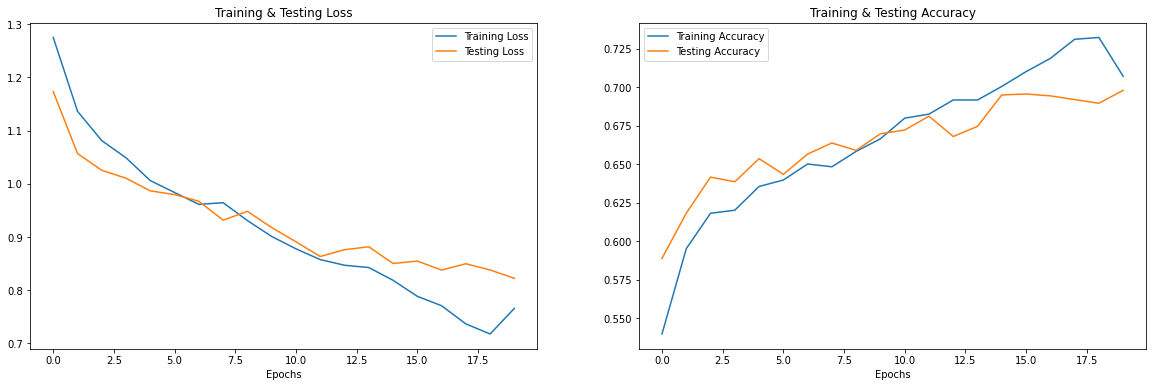

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,angry,angry
2,neutral,neutral
3,angry,angry
4,sad,happy
5,angry,angry
6,neutral,sad
7,angry,angry
8,angry,angry
9,neutral,angry


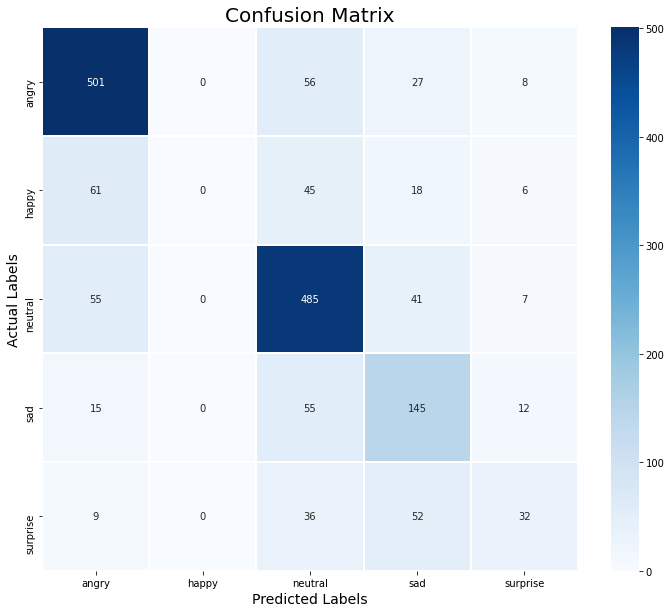

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.83      0.89      0.86       592
       happy       0.52      0.34      0.41       130
     neutral       0.80      0.84      0.82       588
         sad       0.64      0.72      0.68       227
    surprise       0.80      0.43      0.56       129

    accuracy                           0.77      1666
   macro avg       0.72      0.64      0.66      1666
weighted avg       0.76      0.77      0.76      1666

